# Description

The notebooks loads replayed time simulation results, computes research portfolio and computes portfolio-level stats.

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Imports

In [4]:
# TODO(Grisha): Unclear if this should be a separate notebook,
# because most of the code is a copy-paste from the
# `Master_system_reconciliation_fast.py`.
import logging
import os

import pandas as pd

import core.config as cconfig
import core.plotting as coplotti
import dataflow.core as dtfcore
import dataflow.model as dtfmod
import helpers.hdatetime as hdateti
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hpandas as hpandas
import helpers.hprint as hprint
import oms.broker.ccxt.ccxt_utils as obccccut
import optimizer.forecast_evaluator_with_optimizer as ofevwiop
import reconciliation as reconcil

/app/amp/core/explore.py:39: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tauton


In [5]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

INFO: > cmd='/venv/lib/python3.9/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-52cf7267-be13-4e8f-8315-fdda50eed5d8.json'
INFO  # Git
  branch_name='CmTask7726_Add_stats_table_to_the_Master_system_simulator'
  hash='6f57291ea'
  # Last commits:
    * 6f57291ea Danya Tikhomirov Cm task7618 replace annotate forecasts with save portfolio (#7678) (74 minutes ago) Tue Apr 2 11:55:34 2024  (HEAD -> CmTask7726_Add_stats_table_to_the_Master_system_simulator, origin/master, origin/HEAD, origin/CmTask7726_Add_stats_table_to_the_Master_system_simulator, origin/CMTask7754_move_first_part_of_backtest_notebook_into_script)
    * 1ec8b1f2f GP Saggese AmpTask1786_Integrate_20240401_3 (#7760)                          (  12 hours ago) Tue Apr 2 01:21:58 2024  (master) 
    * 3df1e3bd7 GP Saggese Checkpoint (#7758)                                                (  17 hours ago) Mon Apr 1 20:14:05 2024           
# Machine info
  system=Linux
  node name=33cfdfdb417f
  r

# Sim Config

In [6]:
# TODO(Grisha): Can we re-use `build_reconciliation_configs()` to automate the config construction?
system_log_dir = "/shared_data/Samarth/CmTask7253_Run_sim_with_the_optimizer/C12a/simulation/20240228_190000.20240305_19000/system_log_dir/"
system_log_path_dict = {"sim": system_log_dir}
configs = reconcil.load_config_dict_from_pickle(system_log_path_dict)
# TODO(Dan): Deprecate after switch to updated config logs CmTask6627.
hdbg.dassert_in("dag_runner_config", configs["sim"])
if isinstance(configs["sim"]["dag_runner_config"], tuple):
    # This is a hack to display a config that was made from unpickled dict.
    print(configs["sim"].to_string("only_values").replace("\\n", "\n"))
else:
    print(configs["sim"])

WARNING Found Config v1.0 flow: converting
dag_config: ('False', 'None', "generate_features: 
  in_col_groups: [('close',), ('high',), ('low',), ('open',), ('volume',)]
  out_col_group: ()
  transformer_kwargs: 
    features: [('p1', [0.11406, 0.561195, 0.697379, 0.64538, -0.38615]), ('p2', [-0.835831, -0.48463, 0.160771, 1.045835, -0.82349])]
    bar_normalization_method: time
combine_features: 
  in_col_groups: [('p1',), ('p2',)]
  out_col_group: ()
  transformer_kwargs: 
    weights: [('p1', 3.4621), ('p2', 7.95919)]
compute_vol: 
  in_col_groups: [('close',), ('high',), ('low',), ('open',)]
  out_col_group: ()
  transformer_kwargs: 
    estimators: ['close', 'garman_klass']
    open_col: open
    high_col: high
    low_col: low
    close_col: close
    apply_log: True
    take_square_root: False
resample: 
  in_col_groups: [('close',), ('high',), ('low',), ('open',), ('volume',), ('feature',), ('close_var',), ('garman_klass_var',)]
  out_col_group: ()
  transformer_kwargs: 
    rul

# Build config

In [7]:
dag_data_dir = reconcil.get_data_type_system_log_path(system_log_dir, "dag_data")
portfolio_dir = reconcil.get_data_type_system_log_path(
    system_log_dir, "portfolio"
)
# Load pickled SystemConfig.
config_file_name = "system_config.output.values_as_strings.pkl"
system_config_path = os.path.join(system_log_dir, config_file_name)
system_config = cconfig.load_config_from_pickle(system_config_path)
# Get bar duration.
bar_duration_in_secs = reconcil.get_bar_duration_from_config(system_config)
bar_duration = hdateti.convert_seconds_to_pandas_minutes(bar_duration_in_secs)

WARNING Found Config v1.0 flow: converting
WARNING Found Config v1.0 flow: converting


In [8]:
dag_builder_ctor_as_str = (
    "dataflow_lemonade.pipelines.C12.C12a_pipeline.C12a_DagBuilder"
)
dag_builder = dtfcore.get_DagBuilder_from_string(dag_builder_ctor_as_str)
# Get column names from `DagBuilder`.
price_col = dag_builder.get_column_name("price")
prediction_col = dag_builder.get_column_name("prediction")
volatility_col = dag_builder.get_column_name("volatility")
# Get `asset_id_to_share_decimals` from market info.
market_info = obccccut.load_market_data_info()
asset_id_to_share_decimals = obccccut.subset_market_info(
    market_info, "amount_precision"
)

In [9]:
config_dict = {
    "pnl_freq": "H",
    "bar_duration": bar_duration,
    "dag_path_dict": {
        "prod": "",
        "sim": dag_data_dir,
    },
    "portfolio_path_dict": {
        "sim": portfolio_dir,
    },
    "compute_research_portfolio_mode": "sim",
    "research_forecast_evaluator_config": {
        "init": {
            "price_col": price_col,
            "prediction_col": prediction_col,
            "volatility_col": volatility_col,
            # TODO(Grisha): consider extracting sim optimizer_config from SystemConfig if needed.
            "optimizer_config_dict": {
                "dollar_neutrality_penalty": 0.0,
                "constant_correlation": 0.85,
                "constant_correlation_penalty": 1.0,
                "relative_holding_penalty": 0.0,
                "relative_holding_max_frac_of_gmv": 0.6,
                "target_gmv": 1500.0,
                "target_gmv_upper_bound_penalty": 0.0,
                "target_gmv_hard_upper_bound_multiple": 1.0,
                "transaction_cost_penalty": 0.1,
                "solver": "ECOS",
                "verbose": False,
            },
        },
        "annotate_forecasts_kwargs": {
            "quantization": None,
            "liquidate_at_end_of_day": False,
            "initialize_beginning_of_day_trades_to_zero": False,
            "burn_in_bars": 3,
            "asset_id_to_share_decimals": asset_id_to_share_decimals,
        },
    },
}
config = cconfig.Config().from_dict(config_dict)
print(config)

pnl_freq: H
bar_duration: 3T
dag_path_dict: 
  prod: 
  sim: /shared_data/Samarth/CmTask7253_Run_sim_with_the_optimizer/C12a/simulation/20240228_190000.20240305_19000/system_log_dir/dag/node_io/node_io.data
portfolio_path_dict: 
  sim: /shared_data/Samarth/CmTask7253_Run_sim_with_the_optimizer/C12a/simulation/20240228_190000.20240305_19000/system_log_dir/process_forecasts/portfolio
compute_research_portfolio_mode: sim
research_forecast_evaluator_config: 
  init: 
    price_col: open
    prediction_col: feature.c
    volatility_col: garman_klass_vol
    optimizer_config_dict: 
      dollar_neutrality_penalty: 0.0
      constant_correlation: 0.85
      constant_correlation_penalty: 1.0
      relative_holding_penalty: 0.0
      relative_holding_max_frac_of_gmv: 0.6
      target_gmv: 1500.0
      target_gmv_upper_bound_penalty: 0.0
      target_gmv_hard_upper_bound_multiple: 1.0
      transaction_cost_penalty: 0.1
      solver: ECOS
      verbose: False
  annotate_forecasts_kwargs: 
    qu

# Load Portfolio

In [10]:
portfolio_dfs, portfolio_stats_dfs = reconcil.load_portfolio_dfs(
    config["portfolio_path_dict"].to_dict(),
    config["bar_duration"],
)
hpandas.df_to_str(portfolio_dfs["sim"], num_rows=5, log_level=logging.INFO)

INFO  Processing portfolio=sim path=/shared_data/Samarth/CmTask7253_Run_sim_with_the_optimizer/C12a/simulation/20240228_190000.20240305_19000/system_log_dir/process_forecasts/portfolio


Loading `holdings_shares` files...:   0%|          | 0/2881 [00:00<?, ?it/s]

Loading `holdings_notional` files...:   0%|          | 0/2881 [00:00<?, ?it/s]

Loading `executed_trades_shares` files...:   0%|          | 0/2881 [00:00<?, ?it/s]

Loading `executed_trades_notional` files...:   0%|          | 0/2881 [00:00<?, ?it/s]

Loading `statistics` files...:   0%|          | 0/2881 [00:00<?, ?it/s]

holdings_shares            holdings_notional            executed_trades_shares            executed_trades_notional                    pnl           
                               1467591036 1464553467        1464553467 1467591036             1467591036 1464553467               1467591036  1464553467 1464553467 1467591036
2024-02-28 14:00:00-05:00             0.0        0.0               0.0        0.0                    0.0        0.0                      NaN         NaN        NaN        NaN
2024-02-28 14:03:00-05:00          -0.015     -0.181        -603.28024    -923.46                 -0.015     -0.181                 -917.634  -601.29286   -1.98738     -5.826
                                      ...        ...               ...        ...                    ...        ...                      ...         ...        ...        ...
2024-03-05 13:57:00-05:00           0.009       0.25           903.865   576.6201                 -0.005      0.084                 -319.457   302.65116     3.1175     1.5975
2024-03-05 14:00:00-05:00           0.009     -0.249        -900.29685   576.6831                    0.0     -0.499                      0.0 -1804.11454   -0.04731      0.063

## Calculate research Portfolio

In [11]:
fep = ofevwiop.ForecastEvaluatorWithOptimizer(
    **config["research_forecast_evaluator_config"]["init"]
)
annotate_forecasts_kwargs = config["research_forecast_evaluator_config"][
    "annotate_forecasts_kwargs"
].to_dict()
# Get dag data path for research portfolio.
compute_research_portfolio_mode = config["compute_research_portfolio_mode"]
computation_dag_path = reconcil.get_dag_output_path(
    config["dag_path_dict"], compute_research_portfolio_mode
)
# Get computation dataframe for research portfolio.
research_portfolio_input_df = dtfcore.load_dag_outputs(
    computation_dag_path, "predict.7.process_forecasts"
)
research_portfolio_df, research_portfolio_stats_df = fep.annotate_forecasts(
    research_portfolio_input_df,
    **annotate_forecasts_kwargs,
    compute_extended_stats=True,
)
# TODO(Grisha): this is a hack, ideally we should use `close` price
# to compute `holdings_notional` but `open` price to compute `executed_trades_notional`
# shifting the df to make the research PnL look similar to the sim one. See CmTask6902.
research_portfolio_stats_df = research_portfolio_stats_df.shift(-1)
#
hpandas.df_to_str(research_portfolio_stats_df, num_rows=5, log_level=logging.INFO)

  0%|          | 0/2881 [00:00<?, ?it/s]

,pnl,gross_volume,net_volume,gmv,nmv,gpc,npc,wnl
2024-02-28 14:09:00-05:00,-1.4613,1197.1368,-1197.1368,1519.5129,-1519.5129,2.0,-2.0,-2.0
2024-02-28 14:12:00-05:00,6.3954,3022.4577,3022.4577,1509.3402,1509.3402,2.0,2.0,2.0
,...,...,...,...,...,...,...,...
2024-03-05 13:57:00-05:00,4.67926,1800.49908,-1800.49908,1480.4743,-327.2557,2.0,0.0,2.0
2024-03-05 14:00:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# Add research df and combine into a single df.
portfolio_stats_dfs["research"] = research_portfolio_stats_df
portfolio_stats_df = pd.concat(portfolio_stats_dfs, axis=1)
#
hpandas.df_to_str(portfolio_stats_df, num_rows=5, log_level=logging.INFO)

sim                                                                                   research                                                             
                               pnl gross_volume  net_volume         gmv         nmv        cash net_wealth  leverage      pnl gross_volume  net_volume        gmv       nmv  gpc  npc  wnl
2024-02-28 14:00:00-05:00      NaN          0.0         0.0         0.0         0.0       700.0      700.0       0.0      NaN          NaN         NaN        NaN       NaN  NaN  NaN  NaN
2024-02-28 14:03:00-05:00 -7.81338   1518.92686 -1518.92686  1526.74024 -1526.74024  2218.92686  692.18662  2.205677      NaN          NaN         NaN        NaN       NaN  NaN  NaN  NaN
                               ...          ...         ...         ...         ...         ...        ...       ...      ...          ...         ...        ...       ...  ...  ...  ...
2024-03-05 13:57:00-05:00    4.715    622.10816   -16.80584   1480.4851   1480.4851  -934.56072  545.92438  2.711887  4.67926   1800.49908 -1800.49908  1480.4743 -327.2557  2.0  0.0  2.0
2024-03-05 14:00:00-05:00  0.01569   1804.11454 -1804.11454  1476.97995  -323.61375   869.55382  545.94007  2.705388      NaN          NaN         NaN        NaN       NaN  NaN  NaN  NaN

## Plot stats

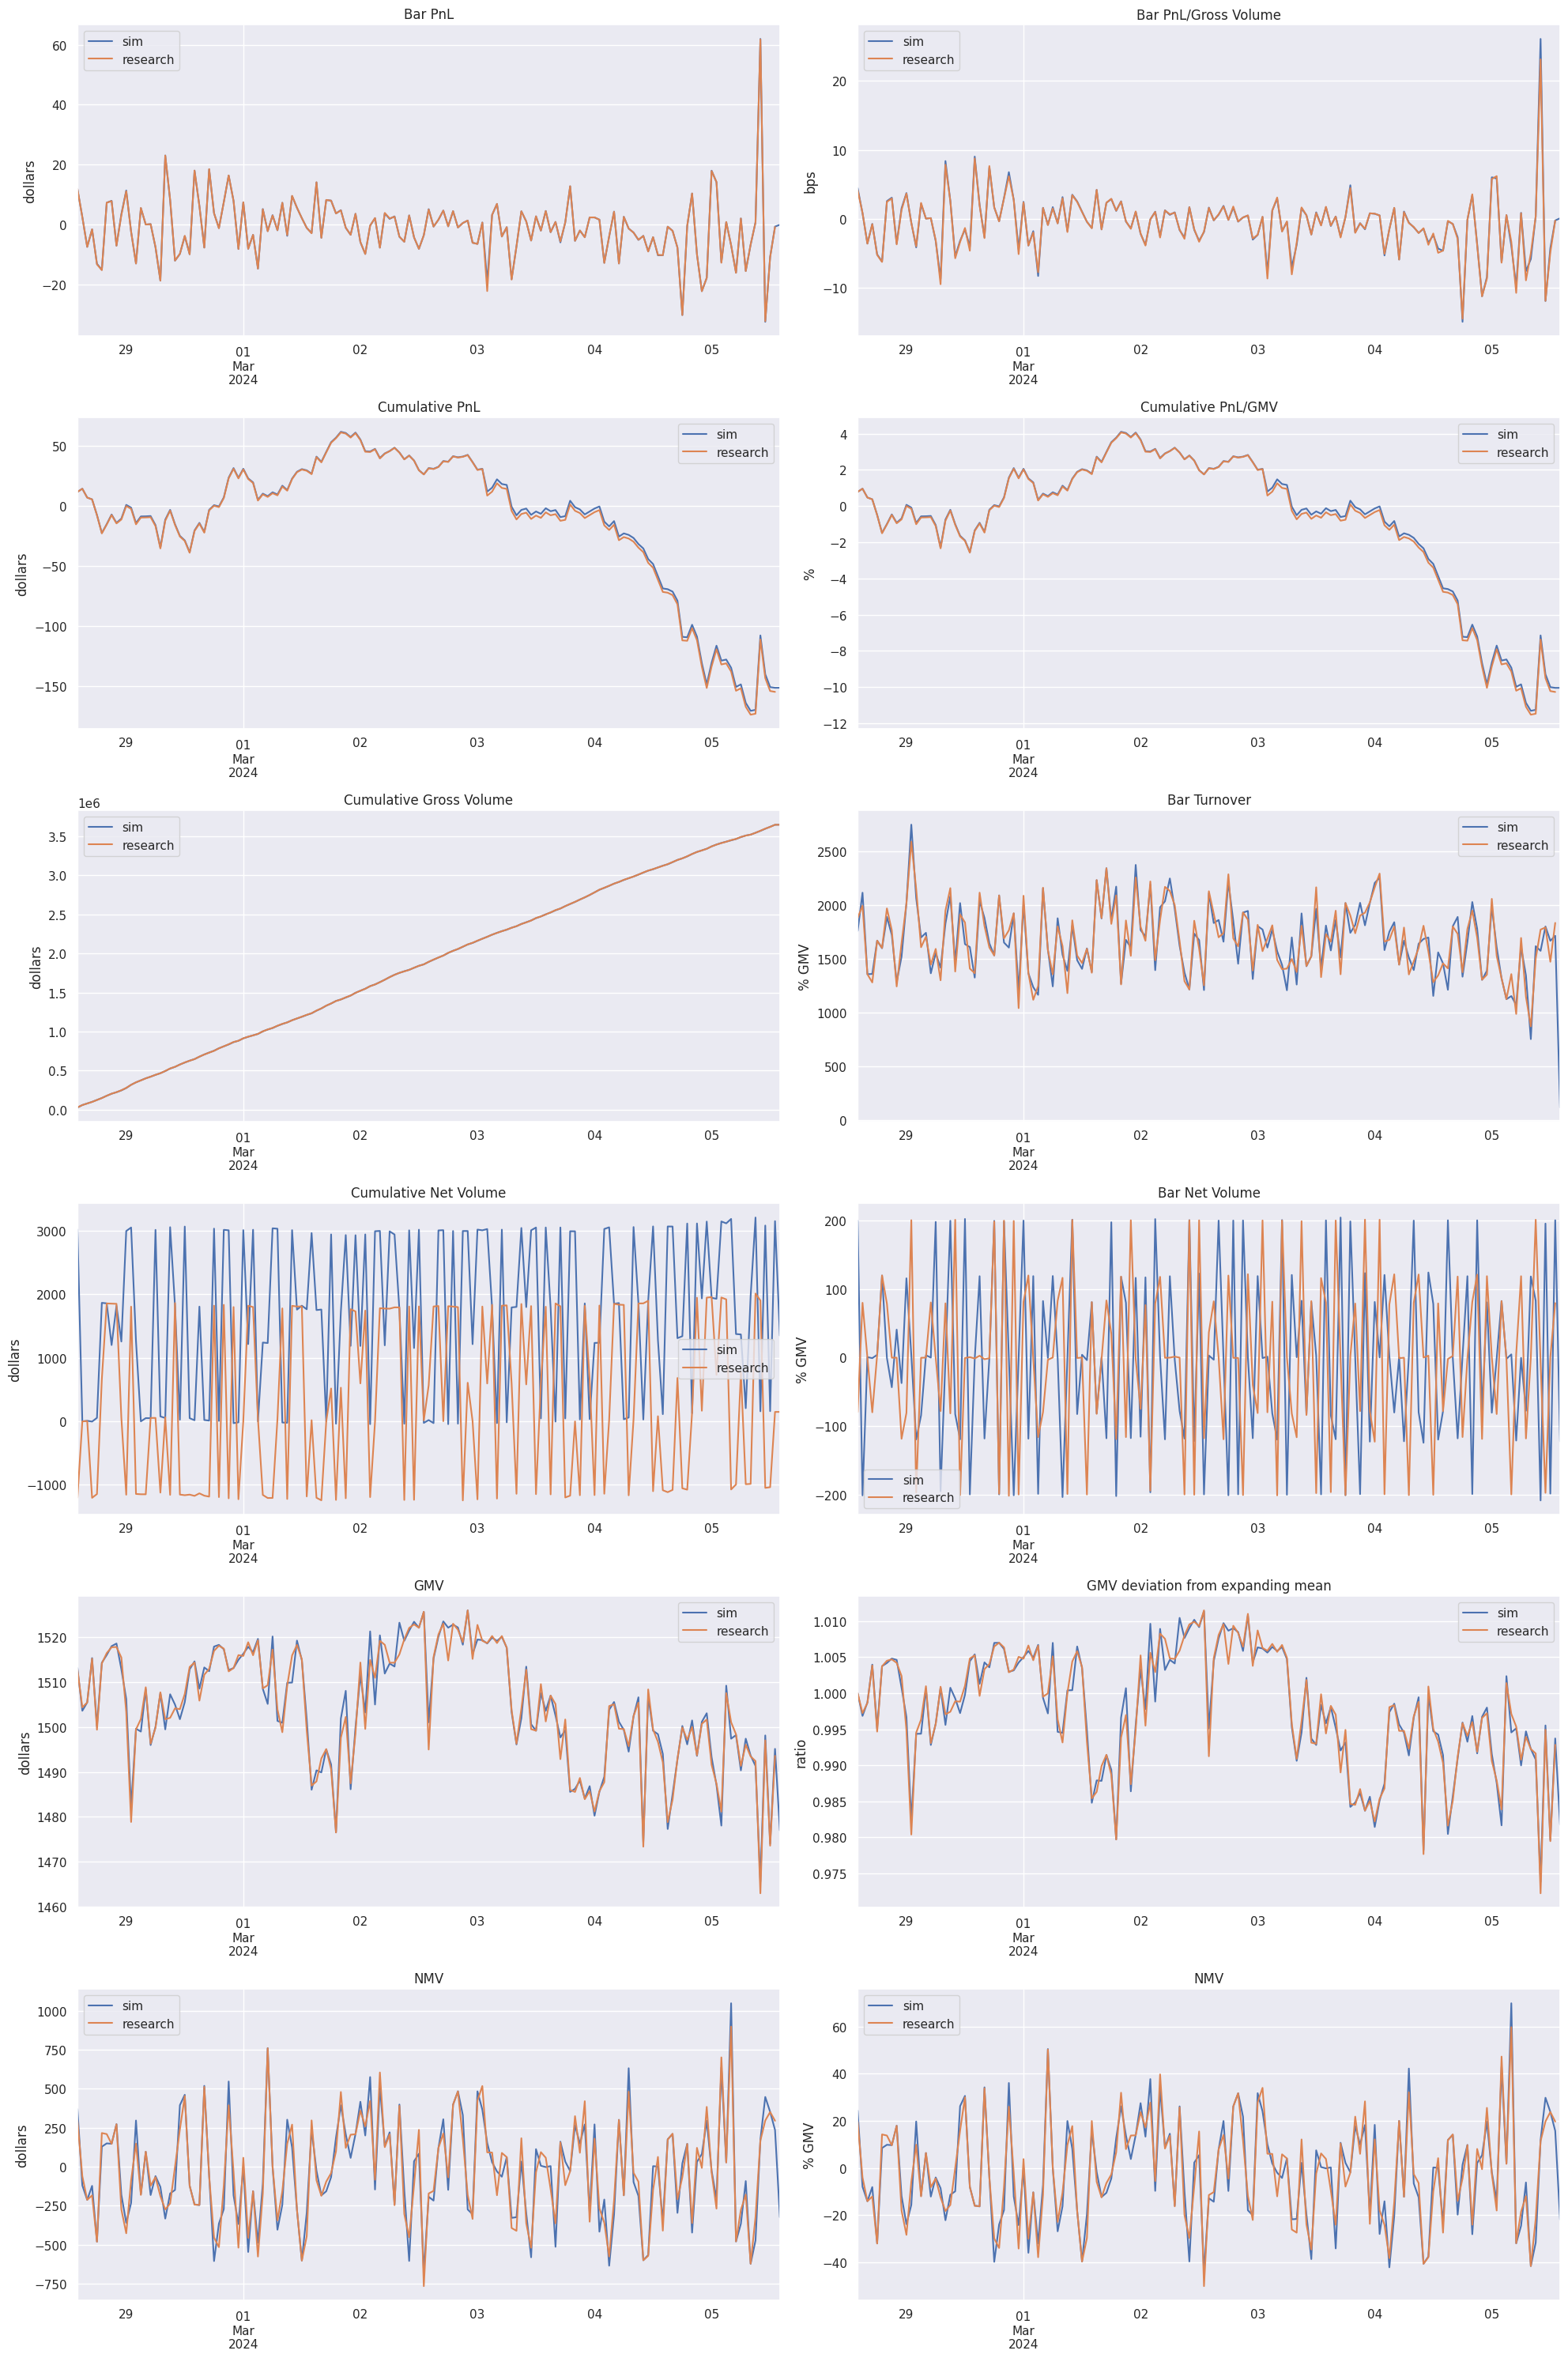

In [13]:
bars_to_burn = config["research_forecast_evaluator_config"][
    "annotate_forecasts_kwargs"
]["burn_in_bars"]
coplotti.plot_portfolio_stats(
    portfolio_stats_df.iloc[bars_to_burn:], freq=config["pnl_freq"]
)

In [15]:
stats_computer = dtfmod.StatsComputer()
stats_sxs, _ = stats_computer.compute_portfolio_stats(
    portfolio_stats_df.iloc[bars_to_burn:], config["bar_duration"]
)
display(stats_sxs)

sim  research
ratios     sharpe_ratio                   -9.84    -10.06
           sharpe_ratio_standard_error     7.81      7.81
           sr.tval                        -1.26     -1.29
           sr.pval                         0.21      0.20
           kratio                         -5.75     -5.90
dollar     gmv_mean                     1504.58   1504.37
           gmv_stdev                      30.72     30.82
           annualized_mean_return      -9201.62  -9408.99
           annualized_volatility         934.88    935.67
           max_drawdown                  241.58    244.29
           pnl_mean                       -0.05     -0.05
           pnl_std                         2.23      2.24
           turnover_mean                1267.90   1267.91
           turnover_stdev               1141.08   1140.80
           market_bias_mean              -25.22    -26.28
           market_bias_stdev            1330.82   1330.87
percentage annualized_mean_return       -611.57   -625.44
           annualized_volatility          62.14     62.20
           max_drawdown                   16.06     16.24
           pnl_mean                       -0.00     -0.00
           pnl_std                         0.15      0.15
           turnover_mean                  84.27     84.28
           turnover_stdev                 75.84     75.83
           market_bias_mean               -1.68     -1.75
           market_bias_stdev              88.45     88.47